In [45]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import Phylo
import requests


Goal: find mutations that precede/enable clades with high numbers of S1 mutations.

Problem encountered: most clades with lots of S1 mutations jump from 1 or 2 S1 mutations to 6 or more with no intermediates. And the one of two were D614G or something else very early on

Get global ncov tree and convert to Bio Phylo format

In [55]:
tree_url = "https://data.nextstrain.org/ncov_global.json"
tree_json = requests.get(tree_url).json()
tree = json_to_tree(tree_json)

Write the latest global ncov tree as a nexus file so it can be viewed in FigTree and the identified clades can be annotated by searching for node name

In [60]:
Phylo.write(tree, "global_tree.nexus", "nexus")

1

In [56]:
# 1: find all mutations that happened on internal branchs of tree
# one instance where a node has {'S': ['E484K']} but no nucleotide mutations??

all_mutations = []

for node in tree.find_clades(terminal=False):

    #just use nucleotide mutations because this includes all syn and nonsyn 
    if hasattr(node, 'branch_attrs'):
        if "nuc" in node.branch_attrs["mutations"]:
            all_mutations += node.branch_attrs["mutations"]['nuc']


all_mutations_unique = list(set(all_mutations))    


Walking through tree, find base of clade with high number of S1 mutations. Use this as the root of the clade, and do not consider nested/children clades.

In [93]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path


def get_clades_and_mutations(threshold, num_branches_back):
    
    
    # keep track of the bases of clades that have already been visited (to avoid looking at nested subclades)
    clade_bases = []

    # initialize list to store dictionaries containing information for each clade 
    # (num S1 mutations and whether not each possible mutation occurred)
    clade_mutation_binary_history = []

    for node in tree.find_clades(terminal=False):

        # clade must have at least 10 tips
        if len(node.get_terminals())>=10:
            if "S1_mutations" in node.node_attrs:
                if node.node_attrs["S1_mutations"]["value"] >=threshold:
                    clade_already_visited = False

                    node_path = get_parent(tree, node)
                    for parent in node_path:
                        if parent in clade_bases:
                            clade_already_visited = True

                    if clade_already_visited == False:
    #                     print(node.__dict__)
                        clade_bases.append(node)

                        #initialize dictionary entry (which will be row in df) for clade
                        clade_row = {'clade': node.name, 'num_s1_muts': node.node_attrs["S1_mutations"]["value"], 
                                     'clade_size': len(node.get_terminals())}

                        for mut in all_mutations_unique:
                            clade_row[mut] = False
                            node_path = get_parent(tree, node)
                            
                            # look at only number of branchs back specified by num_branches_back
                            # and don't consider THIS node, since it is not a parent of itself
                            # if want entire history, specify with num_branches_back='all'
                            if num_branches_back=='all':
                                num_branches_back = len(node_path) - 1
                            
                            for parent in node_path[-(num_branches_back+1):-1]:
                                if hasattr(parent, 'branch_attrs'):
                                    if "nuc" in parent.branch_attrs["mutations"]:
                                        if mut in parent.branch_attrs["mutations"]["nuc"]:
                                            clade_row[mut] = True

                        clade_mutation_binary_history.append(clade_row)

    clade_mut_history_df = pd.DataFrame(clade_mutation_binary_history)
    
    return clade_mut_history_df
                    
            

Take all clades with at least {threshold} S1 mutations (root-to-clade) and find the proportion of these clades where mutation X happened along the path (where X is each possible mutation). Plot the distribution

In [74]:
def plot_distribution(clade_mut_history_df):
    # initialize list of dictionaries containing info about the proportion of clades with 
    # at least 4 S1 mutations and a given mutation
    proportion_of_highs1clades_with_mut = []


    num_clades = len(clade_mut_history_df)
    for observed_mut in all_mutations_unique:
        observed_mut_count = len(clade_mut_history_df[clade_mut_history_df[observed_mut]==True])
        observed_mut_freq = observed_mut_count/num_clades

        proportion_of_highs1clades_with_mut.append({'mutation': observed_mut, 
                                                    'frequency': observed_mut_freq})


    proportion_of_highs1clades_with_mut_df = pd.DataFrame(proportion_of_highs1clades_with_mut)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 8))
    sns.histplot(x = 'frequency', data = proportion_of_highs1clades_with_mut_df, ax=ax1, bins=20)
    sns.histplot(x = 'frequency', data = proportion_of_highs1clades_with_mut_df, bins=50, ax=ax2)
    ax2.set_ylim(0,30)
    ax2.set_xlim(0.0,1.0)
    ax1.set_xlabel('frequency of mutation within S1-mutation-enriched clades')
    ax2.set_xlabel('frequency of mutation within S1-mutation-enriched clades')
    
    return proportion_of_highs1clades_with_mut_df

    # print(proportion_of_highs1clades_with_mut_df[proportion_of_highs1clades_with_mut_df['frequency']!=0.0])


Find the mutations that occur at highest frequency within the clades with at least 4 S1 mutations

In [68]:
top_hits_df = proportion_of_highs1clades_with_mut_df.nlargest(50, 'frequency').reset_index()

Find the location and type (syn or nonsyn) of the top mutations

In [76]:
def show_top_hit_mutations(proportion_of_highs1clades_with_mut_df):

    top_hits_df = proportion_of_highs1clades_with_mut_df.nlargest(50, 'frequency').reset_index()

    #initialize list for new df with location and type info
    top_muts = []

    for k,v in top_hits_df.iterrows():
        nt_mut = v['mutation']

        #convert to 0-based for biopython
        nt_pos = int(nt_mut[1:-1])-1
        #set gene to noncoding, to be overwritten if nt_pos falls in gene
        gene = 'noncoding'
        #set mut_type default to syn, to be overwritten if mutation is nonsyn (unless deletion)
        if nt_mut[-1] == "-":
            mut_type = 'del'
        else:
            mut_type = 'syn'
        #set default aa_mut to None
        aa_mut = None
        for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
            for feature in record.features:
                if feature.type == 'CDS':
                    #find what gene the mut is in
                    if nt_pos in feature.location:
                        gene = feature.qualifiers['gene'][0]
                        if nt_mut[-1] == "-":
                            mut_type = 'del'
                        
                        else:
                            #get nt sequence of the gene
                            gene_nt = feature.location.extract(record.seq)
                            gene_nt_mutated = gene_nt.tomutable()
                            gene_nt_mutated[nt_pos-feature.location.start] = nt_mut[-1]

                            #find what codon mutation occurred in
                            mut_codon = int((nt_pos-feature.location.start)/3)
                            #find the nt sequence and amino acid of codon before and after mut
                            codon_nt = gene_nt[mut_codon*3:mut_codon*3+3]
                            codon_aa = codon_nt.translate()
                            mut_codon_nt = gene_nt_mutated[mut_codon*3:mut_codon*3+3]
                            mut_codon_aa = Seq(str(mut_codon_nt)).translate()
                            #find whether mut was syn or nonsyn
                            if codon_aa != mut_codon_aa:
                                mut_type = 'nonsyn' 
                                #make mut codon 1-based
                                codon_pos = mut_codon +1
                                #need to adjust s1 and s2 to spike numbering
                                if gene == 'S1':
                                    adjust_for_sigpep = codon_pos + 12
                                    aa_mut = f'{codon_aa}{adjust_for_sigpep}{mut_codon_aa}'
                                elif gene == 'S2':
                                    adjust_for_sigpep_and_s1 = codon_pos + 12 + 673
                                    aa_mut = f'{codon_aa}{adjust_for_sigpep_and_s1}{mut_codon_aa}'

                                else:
                                    aa_mut = f'{codon_aa}{codon_pos}{mut_codon_aa}'

        top_muts.append({'mutation': v['mutation'], 
                         'mut_type': mut_type, 'gene': gene, 'aa_mut': aa_mut,
                         'frequency': v['frequency']})

    top_muts_df = pd.DataFrame(top_muts)
    
    print(top_muts_df)



In [86]:
def run_muts_associated_with_highS1clades_analysis(threshold, num_branches_back):
    
    # find non-nested clades with at least {threshold} number of S1 mutations
    # find what mutations happened between the base of the tree and this clade
    clade_mut_history_df = get_clades_and_mutations(threshold, num_branches_back)
    
    print(clade_mut_history_df)
    
    # plot distribution of frequency of mutation in these clades
    proportion_of_highs1clades_with_mut_df = plot_distribution(clade_mut_history_df)
    
    # print table of the mutations that most often occur before clades with lots of S1 mutations
    show_top_hit_mutations(proportion_of_highs1clades_with_mut_df)
    
    

          clade  num_s1_muts  clade_size  G5950T  G11335T  C27972T  C8606T  \
0  NODE_0000236            4          33   False    False    False   False   
1  NODE_0000357            4          15   False    False    False   False   
2  NODE_0001569            4          13   False    False    False   False   
3  NODE_0001635            6         213   False    False    False   False   
4  NODE_0000497            4          15   False    False    False   False   
5  NODE_0000547            7          34   False    False    False   False   
6  NODE_0000521            6          14   False    False    False   False   
7  NODE_0002522            5          26   False    False    False   False   
8  NODE_0002100            9          69   False    False    False   False   
9  NODE_0003188            4         719   False    False    False   False   

   G21770-  G16078A  A27969-  ...  A4197C  A27019G  A29768-  G28188-  G26730T  \
0    False    False    False  ...   False    False    False 

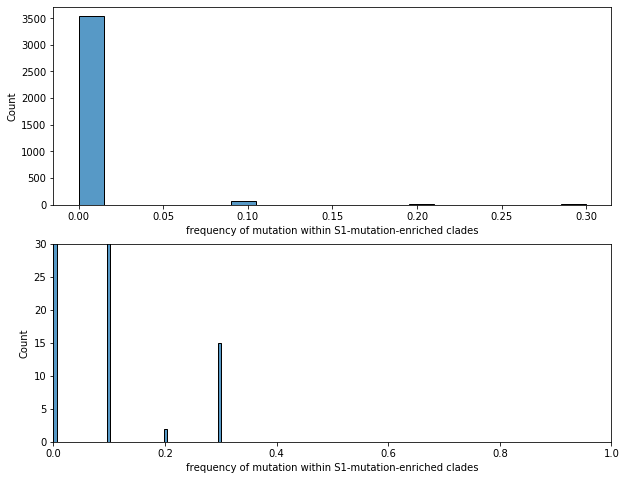

In [94]:
run_muts_associated_with_highS1clades_analysis(4, 3)

           clade  num_s1_muts  clade_size  G5950T  G11335T  C27972T  C8606T  \
0   NODE_0000233            3          36   False    False    False   False   
1   NODE_0000344            3          47   False    False    False   False   
2   NODE_0001021            3          27   False    False    False   False   
3   NODE_0001497            3          12   False    False    False   False   
4   NODE_0001540            3          61   False    False    False   False   
5   NODE_0001635            6         213   False    False    False   False   
6   NODE_0001910            3          12   False    False    False   False   
7   NODE_0000493            3          19   False    False    False   False   
8   NODE_0000547            7          34   False    False    False   False   
9   NODE_0000635            3          10   False    False    False   False   
10  NODE_0000670            3          37   False    False    False   False   
11  NODE_0000512            3          23   False   

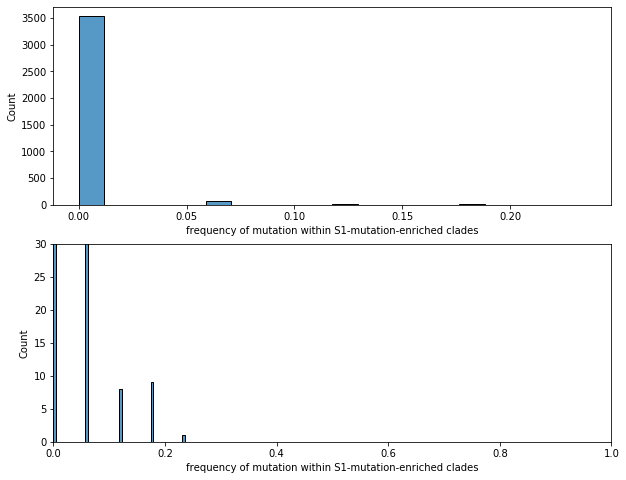

In [99]:
run_muts_associated_with_highS1clades_analysis(3, 3)

          clade  num_s1_muts  clade_size  G5950T  G11335T  C27972T  C8606T  \
0  NODE_0001635            6         213   False    False    False   False   
1  NODE_0000547            7          34   False    False    False   False   
2  NODE_0000521            6          14   False    False    False   False   
3  NODE_0002522            5          26   False    False    False   False   
4  NODE_0002100            9          69   False    False    False   False   
5  NODE_0003189            6         718   False    False    False   False   

   G21770-  G16078A  A27969-  ...  A4197C  A27019G  A29768-  G28188-  G26730T  \
0    False    False    False  ...   False    False    False    False    False   
1     True    False    False  ...   False    False     True    False    False   
2    False    False    False  ...   False    False    False    False    False   
3    False    False    False  ...   False    False    False    False    False   
4    False    False    False  ...   False    Fal

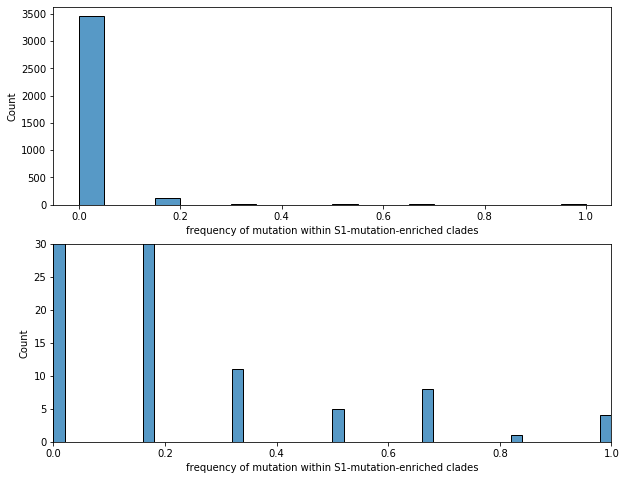

In [81]:
run_muts_associated_with_highS1clades_analysis(5)

Each of these clades with high numbers of S1 mutations is an emerging clade:

clade 0 = B.1.351
clade 1 = B.1.525
clade 2 = B.1.617
clade 3 = C.37
clade 4 = P.1
clade 5 = A.23.1


          clade  num_s1_muts  clade_size  G5950T  G11335T  C27972T  C8606T  \
0  NODE_0001635            6         213   False    False    False   False   
1  NODE_0000547            7          34   False    False    False   False   
2  NODE_0000521            6          14   False    False    False   False   
3  NODE_0002523            6          25   False    False    False   False   
4  NODE_0002100            9          69   False    False    False   False   
5  NODE_0003189            6         718   False    False    False   False   

   G21770-  G16078A  A27969-  ...  A4197C  A27019G  A29768-  G28188-  G26730T  \
0    False    False    False  ...   False    False    False    False    False   
1     True    False    False  ...   False    False     True    False    False   
2    False    False    False  ...   False    False    False    False    False   
3    False    False    False  ...   False    False    False    False    False   
4    False    False    False  ...   False    Fal

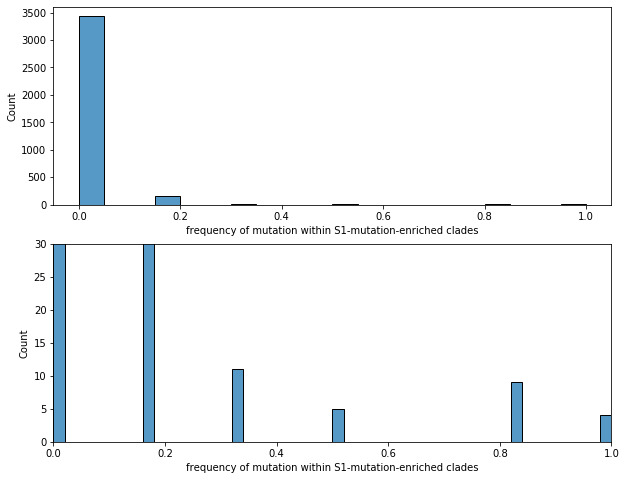

In [82]:
run_muts_associated_with_highS1clades_analysis(6, 'all')